In [1]:
import os
import cv2
import numpy as np
from glob import glob

# ====================== CONFIGURACIÓN ======================
IMAGES_DIR = "/kaggle/input/dataset-inferencia-lol-br-038/dataset_inference_lol_038/images"           # carpeta de entrada de imágenes .png
TARGET_IMG = "/kaggle/input/referencia/reffff.png"  # imagen objetivo con la tinción "ideal"
OUT_IMAGES_DIR = "/kaggle/working/dataset_normalized/images"  # carpeta de salida de imágenes

os.makedirs(OUT_IMAGES_DIR, exist_ok=True)

# ====================== PARÁMETROS DE NORMALIZACIÓN ======================
# Máscara de tejido vs fondo
S_THRESH = 20          # saturación mínima para considerar tejido (HSV)
V_MAX_BG = 245         # tope de V para descartar fondo blanco muy brillante
L_MAX_BG = 245         # tope de L* en Lab para considerar fondo blanco

# Control de normalización
BLEND_L = 0.5          # mezcla para L*: 0=preservar L original, 1=reemplazar por L normalizado
LIMIT_STD = 1e-6       # para evitar división por cero en std

# Recorte robusto para medias/desviaciones (mitiga outliers)
P_LO = 1.0
P_HI = 99.0

# Guardado opcional
SAVE_MASKS = False     # exportar máscara de tejido para inspección

# ====================== UTILIDADES DE COLOR ======================
def bgr_to_lab(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)

def lab_to_bgr(img_lab_float):
    img_lab = np.clip(img_lab_float, 0, 255).astype(np.uint8)
    return cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

# ====================== MÁSCARAS Y ESTADÍSTICOS ======================
def get_tissue_mask(img_bgr):
    """
    Máscara booleana de tejido:
      - Tejido típico con saturación suficiente y no extremadamente brillante.
      - Se limpia con operaciones morfológicas.
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    _, s, v = cv2.split(hsv)
    lab = bgr_to_lab(img_bgr)
    L, _, _ = cv2.split(lab)

    tissue = (s > S_THRESH) & (v < V_MAX_BG) & (L < L_MAX_BG)

    tissue_u8 = tissue.astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    tissue_u8 = cv2.morphologyEx(tissue_u8, cv2.MORPH_OPEN, kernel, iterations=1)
    tissue_u8 = cv2.morphologyEx(tissue_u8, cv2.MORPH_CLOSE, kernel, iterations=1)

    return tissue_u8.astype(bool)

def robust_mean_std(x, mask=None, p_lo=P_LO, p_hi=P_HI):
    """
    Media y desviación estándar robustas con recorte por percentiles.
    """
    if mask is not None:
        vals = x[mask]
    else:
        vals = x.reshape(-1)

    if vals.size == 0:
        return float(np.mean(x)), float(np.std(x) + LIMIT_STD)

    lo = np.percentile(vals, p_lo)
    hi = np.percentile(vals, p_hi)
    vals_clip = vals[(vals >= lo) & (vals <= hi)]
    if vals_clip.size == 0:
        vals_clip = vals

    return float(np.mean(vals_clip)), float(np.std(vals_clip) + LIMIT_STD)

def compute_lab_stats(img_bgr):
    """
    Estadísticos Lab del TARGET calculados solo sobre tejido (robustos).
    """
    lab = bgr_to_lab(img_bgr)
    L, a, b = cv2.split(lab)
    tissue = get_tissue_mask(img_bgr)

    L_mean, L_std = robust_mean_std(L, tissue)
    a_mean, a_std = robust_mean_std(a, tissue)
    b_mean, b_std = robust_mean_std(b, tissue)

    return {
        "L_mean": L_mean, "L_std": L_std,
        "a_mean": a_mean, "a_std": a_std,
        "b_mean": b_mean, "b_std": b_std,
    }

# ====================== REINHARD CON MÁSCARA Y PROTECCIÓN ======================
def reinhard_normalize(src_bgr, target_stats):
    """
    Normalización tipo Reinhard con:
      - Estadísticos de la fuente solo en tejido.
      - Protección del fondo (blanco/alto L*).
      - Mezcla de L* con BLEND_L para no perder brillo del tejido.
      - Normalización completa en a/b y moderada en L*.
    """
    lab = bgr_to_lab(src_bgr)
    L, a, b = cv2.split(lab)

    tissue = get_tissue_mask(src_bgr)

    hsv = cv2.cvtColor(src_bgr, cv2.COLOR_BGR2HSV)
    _, s, v = cv2.split(hsv)
    bg_light = ((s <= S_THRESH) & (v >= V_MAX_BG)) | (L >= L_MAX_BG)

    L_mu_s, L_sd_s = robust_mean_std(L, tissue)
    a_mu_s, a_sd_s = robust_mean_std(a, tissue)
    b_mu_s, b_sd_s = robust_mean_std(b, tissue)

    def norm_to_target(ch, mu_src, sd_src, mu_t, sd_t):
        chn = (ch - mu_src) / (sd_src + LIMIT_STD)
        return chn * sd_t + mu_t

    L_t = norm_to_target(L, L_mu_s, L_sd_s, target_stats["L_mean"], target_stats["L_std"])
    a_t = norm_to_target(a, a_mu_s, a_sd_s, target_stats["a_mean"], target_stats["a_std"])
    b_t = norm_to_target(b, b_mu_s, b_sd_s, target_stats["b_mean"], target_stats["b_std"])

    # Mezcla en L*
    L_out = (1.0 - BLEND_L) * L + BLEND_L * L_t

    # Proteger fondo
    L_out[bg_light] = L[bg_light]
    a_t[bg_light] = a[bg_light]
    b_t[bg_light] = b[bg_light]

    lab_t = cv2.merge([L_out, a_t, b_t])
    out_bgr = lab_to_bgr(lab_t)
    return out_bgr

# ====================== PREPARAR ESTADÍSTICA OBJETIVO ======================
if not os.path.exists(TARGET_IMG):
    raise FileNotFoundError(f"No se encontró la imagen objetivo: {TARGET_IMG}")

target_bgr = cv2.imread(TARGET_IMG, cv2.IMREAD_COLOR)
if target_bgr is None:
    raise RuntimeError("Error leyendo la imagen objetivo. Verifica ruta y formato.")

target_stats = compute_lab_stats(target_bgr)

# ====================== PROCESAMIENTO POR LOTES ============================
pngs = sorted(glob(os.path.join(IMAGES_DIR, "*.png")))
if not pngs:
    raise RuntimeError(f"No hay .png en {IMAGES_DIR}")

for i, img_path in enumerate(pngs, 1):
    fname = os.path.basename(img_path)

    src_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if src_bgr is None:
        print(f"[WARN] No pude leer {img_path}, salto.")
        continue

    h0, w0 = src_bgr.shape[:2]

    if SAVE_MASKS:
        mask = get_tissue_mask(src_bgr).astype(np.uint8) * 255
        base, _ = os.path.splitext(fname)
        cv2.imwrite(os.path.join(OUT_IMAGES_DIR, f"{base}_mask.png"), mask)

    out_bgr = reinhard_normalize(src_bgr, target_stats)

    h1, w1 = out_bgr.shape[:2]
    if (h0, w0) != (h1, w1):
        raise RuntimeError("Las dimensiones cambiaron, algo salió mal.")

    out_path = os.path.join(OUT_IMAGES_DIR, fname)
    ok = cv2.imwrite(out_path, out_bgr)
    if not ok:
        raise RuntimeError(f"No pude escribir {out_path}")

    if i % 25 == 0 or i == len(pngs):
        print(f"Procesadas {i}/{len(pngs)}")

print("Listo: imágenes normalizadas en", OUT_IMAGES_DIR)


Procesadas 25/176
Procesadas 50/176
Procesadas 75/176
Procesadas 100/176
Procesadas 125/176
Procesadas 150/176
Procesadas 175/176
Procesadas 176/176
Listo: imágenes normalizadas en /kaggle/working/dataset_normalized/images


# **Ultralytics**

In [2]:
%pip install -q ultralytics==8.2.103

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 15.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 27.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━

In [3]:
# Hot-swap de Ultralytics en Kaggle (Internet ON)
import sys, subprocess

TARGET = "8.3.217"           # alternativa muy estable
# TARGET = "8.2.103"         # plan B si aún ves cuelgues

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--no-cache-dir", f"ultralytics=={TARGET}"])

# Purgar módulos cargados y reimportar (sin reiniciar kernel)
for k in list(sys.modules):
    if k.startswith("ultralytics"):
        del sys.modules[k]

import ultralytics
from ultralytics import YOLO
print("Ultralytics:", ultralytics.__version__, "OK ✅")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics: 8.3.217 OK ✅


# **Inference**

In [4]:
'''
# -*- coding: utf-8 -*-
import os
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

import csv
from pathlib import Path
import numpy as np
import cv2
from ultralytics import YOLO
from collections import defaultdict
import gc
import torch
import math

# =========================
# CONFIG (AJUSTA ESTO)
# =========================
MODEL_PATH  = "/kaggle/input/best-color/pytorch/default/1/best another color.pt"
TILES_DIR   = "/kaggle/working/dataset_normalized/images"
OFFSETS_CSV = "/kaggle/input/dataset-inference/dataset_inference_lol/tile_offsets.csv"

# INFERENCIA (memoria segura)
IMG_SIZE   = 1024         # primer intento; se degrada a 896 -> 768 si falta VRAM
NMS_IOU    = 0.65         # un poco más estricto para reducir duplicados intra-tile
USE_HALF   = True         # FP16 en GPU

# UMBRALES / FILTROS
CONF_TH = 0.50  # umbral global más estricto
CLASS_CONF = {  # umbral por clase (si no aparece la clase, usa CONF_TH)
    0: 0.55,  # no_proliferativo
    1: 0.50,  # proliferativo
    2: 0.50,  # esclerosado
    3: 0.60,  # exclude
}
MIN_AREA_PX = 24 * 24                 # descarta microcajas
MAX_AREA_FRAC_TILE = 0.60             # descarta monstruos >60% del tile
CLUSTER_MIN_CONF = 0.50               # conf mínima del mejor miembro del componente

# Borde “suave”
EDGE_TOL_MIN = 4                      # px
EDGE_TOL_MAX = 12                     # px
EDGE_TOL_PCT = 0.008                  # 0.8% lado corto del tile
ALLOW_ONE_SIDE = True                 # solo marcamos edge si toca >=2 lados

# GRAFO DE FUSIÓN ENTRE TILES (global)
GRAPH_IOU_THR   = 0.30                # IoU para conectar nodos (después de dilatar)
GRAPH_DILATE_PX = 48                  # dilatación de cajas antes del IoU (px globales)
CENTER_ABS_MAX  = 160                 # umbral absoluto de centros (px globales)
CENTER_REL_FRAC = 0.45                # fracción del lado corto típico del bbox

# NMS final entre winners
FINAL_NMS_IOU   = 0.60
FINAL_CENTER_FR = 0.35                # fracción del lado corto mediano

# SALIDAS
OUT_DIR     = "./winners_vis"
WINNERS_CSV = "./winners_global.csv"

# nombres de clases (opcional)
CLASS_NAMES = ['no_proliferativo', 'proliferativo', 'esclerosado', 'exclude']

# =========================
# UTILIDADES
# =========================
def read_offsets(csv_path):
    """Lee CSV de offsets. Requiere: tile_name, tx, ty, tile_width, tile_height."""
    def norm(s): return s.strip().lower()
    mapping = {}
    with open(csv_path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = [norm(h) for h in next(reader)]
        def idx(*cands):
            for c in cands:
                if c in header:
                    return header.index(c)
            return None

        i_name = idx("tile_name", "name", "filename", "file", "tile")
        i_tx   = idx("tx","x","global_x","global_x1")
        i_ty   = idx("ty","y","global_y","global_y1")
        i_tw   = idx("tile_width","tw","w","width")
        i_th   = idx("tile_height","th","h","height")
        if None in (i_name, i_tx, i_ty, i_tw, i_th):
            raise ValueError("El CSV debe tener columnas: tile_name, tx, ty, tile_width, tile_height")

        for row in reader:
            raw_name = row[i_name]
            p = Path(raw_name)
            stem = p.stem
            name_no_ext = p.name.rsplit('.', 1)[0]
            name_with_ext = p.name
            tx = int(float(row[i_tx])); ty = int(float(row[i_ty]))
            tw = int(float(row[i_tw])); th = int(float(row[i_th]))
            for key in {stem, name_no_ext, name_with_ext}:
                mapping[key] = (tx, ty, tw, th)
    return mapping

def xyxy_iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1 = max(ax1, bx1); iy1 = max(ay1, by1)
    ix2 = min(ax2, bx2); iy2 = min(ay2, by2)
    iw = max(0.0, ix2 - ix1); ih = max(0.0, iy2 - iy1)
    inter = iw * ih
    if inter <= 0:
        return 0.0
    area_a = max(0.0, ax2-ax1) * max(0.0, ay2-ay1)
    area_b = max(0.0, bx2-bx1) * max(0.0, by2-by1)
    return inter / (area_a + area_b - inter + 1e-6)

def _wh(xyxy):
    x1,y1,x2,y2 = xyxy
    return (max(0.0, x2-x1), max(0.0, y2-y1))

def _center(xyxy):
    x1,y1,x2,y2 = xyxy
    return ((x1+x2)*0.5, (y1+y2)*0.5)
def touches_edge(local_xyxy, tile_w, tile_h, tol_px, allow_one_side=True):
    """True si la caja toca borde. Con allow_one_side=True, exige tocar ≥2 lados para marcar edge."""
    x1, y1, x2, y2 = local_xyxy
    left  = x1
    top   = y1
    right = tile_w - x2
    bot   = tile_h - y2
    near = sum(1 for m in (left, top, right, bot) if m <= tol_px)
    return (near >= 2) if allow_one_side else (near >= 1)

def local_to_global(tx, ty, local_xyxy):
    x1,y1,x2,y2 = local_xyxy
    return (tx+x1, ty+y1, tx+x2, ty+y2)

def _completeness_margin(m):
    x1,y1,x2,y2 = m["local_xyxy"]
    twr = m.get("tile_w_real", m["tw"])
    thr = m.get("tile_h_real", m["th"])
    left, top, right, bot = x1, y1, twr - x2, thr - y2
    return min(left, top, right, bot)

def _winner_score(m):
    # mayor margen → mayor área → mayor conf
    x1,y1,x2,y2 = m["local_xyxy"]
    area = (x2-x1)*(y2-y1)
    return (_completeness_margin(m), area, m["conf"])

def _dilate(xyxy, px):
    x1,y1,x2,y2 = xyxy
    return (x1-px, y1-px, x2+px, y2+px)

# =========================
# INFERENCIA + AGRUPACIÓN
# =========================
def run_and_pick_winners(model_path, tiles_dir, offsets_csv,
                         conf_th=CONF_TH, nms_iou=NMS_IOU, imgsz=IMG_SIZE, use_half=USE_HALF):
    offsets = read_offsets(offsets_csv)
    tile_paths = sorted(list(Path(tiles_dir).glob("*.png")) + list(Path(tiles_dir).glob("*.jpg")))
    if not tile_paths:
        raise FileNotFoundError("No se encontraron imágenes .png / .jpg en TILES_DIR.")

    # modelos separados (GPU/CPU)
    model_gpu = YOLO(model_path)
    cpu_model = None

    def _predict_one(path_str, imgsz_try, use_cpu=False):
        nonlocal cpu_model
        m = model_gpu
        device_arg = 0
        half_arg = use_half
        if use_cpu:
            if cpu_model is None:
                cpu_model = YOLO(model_path)
            m = cpu_model
            device_arg = "cpu"
            half_arg = False
        return m.predict(
            source=path_str,
            conf=conf_th,
            iou=nms_iou,
            imgsz=imgsz_try,
            verbose=False,
            stream=False,
            batch=1,
            device=device_arg,
            half=half_arg,
            workers=0
        )

    dets = []
    for img_path in tile_paths:
        key = img_path.stem if img_path.stem in offsets else img_path.name
        if key not in offsets:
            continue
        tx,ty,tw,th = offsets[key]

        img = cv2.imread(str(img_path))
        if img is None:
            continue
        ih, iw = img.shape[:2]

        # tolerancia dinámica (suave y acotada)
        tol_px = int(EDGE_TOL_PCT * min(iw, ih))
        tol_px = max(EDGE_TOL_MIN, min(EDGE_TOL_MAX, tol_px))

        # inferencia con degradación + fallback CPU
        results = None
        for sz in [imgsz, 896, 768]:
            try:
                results = _predict_one(str(img_path), sz, use_cpu=False)
                break
            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise
        if results is None:
            results = _predict_one(str(img_path), 768, use_cpu=True)

        r = results[0]
        if r.boxes is not None and len(r.boxes) > 0:
            for i in range(len(r.boxes)):
                b = r.boxes[i]
                x1,y1,x2,y2 = b.xyxy[0].detach().cpu().numpy().tolist()
                conf = float(b.conf.item())
                cls  = int(b.cls.item()) if b.cls is not None else -1

                # Filtros
                conf_th_cls = CLASS_CONF.get(cls, conf_th)
                if conf < conf_th_cls:
                    continue
                w = max(0.0, x2-x1); h = max(0.0, y2-y1)
                area = w*h
                tile_area = iw*ih
                if area < MIN_AREA_PX or area > (MAX_AREA_FRAC_TILE * tile_area):
                    continue
                loc_xyxy = (x1,y1,x2,y2)
                glob_xyxy = local_to_global(tx,ty,loc_xyxy)
                edge_flag = touches_edge(loc_xyxy, iw, ih, tol_px, allow_one_side=ALLOW_ONE_SIDE)

                dets.append({
                    "tile_path": str(img_path),
                    "tile_key": key,
                    "tx": tx, "ty": ty, "tw": tw, "th": th,
                    "tile_w_real": iw, "tile_h_real": ih,
                    "edge_tol_px": tol_px,
                    "local_xyxy": loc_xyxy,
                    "global_xyxy": glob_xyxy,
                    "conf": conf,
                    "cls": cls,
                    "edge": edge_flag
                })

        del results
        gc.collect()
        try: torch.cuda.empty_cache()
        except Exception: pass

    if not dets:
        print("No hubo detecciones.")
        return [], [], []

    # ====== CLUSTERING POR COMPONENTES CONEXAS (UNION-FIND) ======
    dets_sorted = sorted(dets, key=lambda d: d["conf"], reverse=True)

    # tamaño típico del glomérulo (lado corto mediano)
    minsides = []
    for d in dets_sorted:
        w,h = _wh(d["global_xyxy"])
        minsides.append(min(w,h))
    med_side = float(np.median(minsides)) if minsides else 128.0

    # umbral de centros adaptativo
    center_thr = max(CENTER_ABS_MAX, CENTER_REL_FRAC * med_side)
    center_thr2 = center_thr * center_thr

    n = len(dets_sorted)
    parent = list(range(n))
    rank = [0]*n

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb: return
        if rank[ra] < rank[rb]:
            parent[ra] = rb
        elif rank[ra] > rank[rb]:
            parent[rb] = ra
        else:
            parent[rb] = ra
            rank[ra] += 1

    # conectamos pares si IoU(dilatado) alto O centros cercanos
    for i in range(n):
        gi = dets_sorted[i]["global_xyxy"]
        di = _dilate(gi, GRAPH_DILATE_PX)
        ci = _center(gi)
        for j in range(i+1, n):
            gj = dets_sorted[j]["global_xyxy"]
            # criterio centro
            cj = _center(gj)
            dx = ci[0]-cj[0]; dy = ci[1]-cj[1]
            if dx*dx + dy*dy <= center_thr2:
                union(i, j)
                continue
            # criterio IoU con dilatación
            if xyxy_iou(di, _dilate(gj, GRAPH_DILATE_PX)) >= GRAPH_IOU_THR:
                union(i, j)

    # componentes -> clusters
    comp = defaultdict(list)
    for idx in range(n):
        comp[find(idx)].append(dets_sorted[idx])

    # filtra clusters débiles
    clusters = []
    for members in comp.values():
        if max(m["conf"] for m in members) < CLUSTER_MIN_CONF:
            continue
        # “representante” solo para depuración
        cx = np.mean([_center(m["global_xyxy"])[0] for m in members])
        cy = np.mean([_center(m["global_xyxy"])[1] for m in members])
        clusters.append({"members": members, "rep": (cx, cy)})

    # clase consolidada = mayor confianza dentro del cluster
    def _cluster_class(cl):
        top = max(cl["members"], key=lambda m: m["conf"])
        return top["cls"]

    # elegir UN ganador por cluster (no-edge -> margen -> área -> conf)
    winners = []
    for cl_id, cl in enumerate(clusters):
        complete = [m for m in cl["members"] if not m["edge"]]
        cands = complete if complete else cl["members"]
        winner = max(cands, key=_winner_score)
        wcopy = dict(winner)
        wcopy["cluster_id"] = cl_id
        wcopy["cls"] = _cluster_class(cl)
        winners.append(wcopy)
        # NMS final entre winners (por si dos componentes quedaron muy pegadas)
    def _nms_final(ws, iou_thr=FINAL_NMS_IOU, center_fr=FINAL_CENTER_FR):
        kept = []
        used = [False]*len(ws)
        # escala del centro: fracción del lado corto mediano
        cthr = center_fr * med_side
        cthr2 = cthr * cthr
        order = sorted(range(len(ws)), key=lambda i: _winner_score(ws[i]), reverse=True)

        def _c(m):
            x1,y1,x2,y2 = m["global_xyxy"]; return ((x1+x2)/2.0, (y1+y2)/2.0)

        for i in order:
            if used[i]: continue
            kept.append(ws[i]); used[i] = True
            gi = ws[i]["global_xyxy"]; ci = _c(ws[i])
            for j in order:
                if used[j]: continue
                gj = ws[j]["global_xyxy"]; cj = _c(ws[j])
                dx = ci[0]-cj[0]; dy = ci[1]-cj[1]
                if xyxy_iou(gi, gj) >= iou_thr or (dx*dx+dy*dy) <= cthr2:
                    used[j] = True
        return kept

    winners = _nms_final(winners)

    return winners, clusters, dets

# =========================
# VISUALIZACIÓN + EXPORT
# =========================
def draw_and_save_winners(winners, out_dir="./winners_vis", only_complete=False):
    """Dibuja GANADORES por tile. Verde= completo; Naranja= edge."""
    os.makedirs(out_dir, exist_ok=True)
    by_tile = defaultdict(list)
    for w in winners:
        if only_complete and w["edge"]:
            continue
        by_tile[w["tile_path"]].append(w)
    for tile_path, ws in by_tile.items():
        img = cv2.imread(tile_path)
        if img is None: continue
        for w in ws:
            x1,y1,x2,y2 = map(int, w["local_xyxy"])
            color = (0,255,0) if not w["edge"] else (0,165,255)
            cname = CLASS_NAMES[w["cls"]] if 0 <= w["cls"] < len(CLASS_NAMES) else str(w["cls"])
            cv2.rectangle(img, (x1,y1), (x2,y2), color, 3)
            cv2.putText(img, f"{cname} {w['conf']:.2f}", (x1, max(0,y1-8)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)
        out_path = Path(out_dir) / (Path(tile_path).stem + "_WIN.png")
        cv2.imwrite(str(out_path), img)
    print(f"✅ Tiles ganadores guardados en: {out_dir}")

def save_winners_csv(winners, out_csv="./winners_global.csv"):
    """CSV: cluster_id, tile_path, cls, conf, local/global, edge, offsets."""
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        wr = csv.writer(f)
        wr.writerow(["cluster_id", "tile_path", "class_id", "class_name", "conf",
                     "local_x1","local_y1","local_x2","local_y2",
                     "global_x1","global_y1","global_x2","global_y2",
                     "edge", "edge_tol_px", "tx","ty","tw","th"])
        for w in winners:
            x1,y1,x2,y2 = w["local_xyxy"]
            gx1,gy1,gx2,gy2 = w["global_xyxy"]
            cid = w["cls"]
            cname = CLASS_NAMES[cid] if 0 <= cid < len(CLASS_NAMES) else str(cid)
            wr.writerow([w.get("cluster_id", -1), w["tile_path"], cid, cname, f"{w['conf']:.4f}",
                         f"{x1:.1f}",f"{y1:.1f}",f"{x2:.1f}",f"{y2:.1f}",
                         f"{gx1:.1f}",f"{gy1:.1f}",f"{gx2:.1f}",f"{gy2:.1f}",
                         int(w["edge"]), w.get("edge_tol_px", EDGE_TOL_MIN), w["tx"], w["ty"], w["tw"], w["th"]])
    print(f"✅ CSV de ganadores guardado en: {out_csv}")

def print_per_tile_summary(clusters, winners):
    """Resumen por tile de TODOS los miembros de cada componente; ★ marca al ganador."""
    winner_keys = {(w["tile_path"], tuple(map(lambda z: round(z,3), w["local_xyxy"])), w["cls"], round(w["conf"],4)) for w in winners}
    by_tile = defaultdict(list)
    for cl in clusters:
        for m in cl["members"]:
            key = (m["tile_path"], tuple(map(lambda z: round(z,3), m["local_xyxy"])), m["cls"], round(m["conf"],4))
            mark = "★" if key in winner_keys else " "
            by_tile[m["tile_path"]].append((mark, m))
    for tile_path in sorted(by_tile.keys()):
        rows = sorted(by_tile[tile_path], key=lambda t: t[1]["conf"], reverse=True)
        print(f"\n--- {Path(tile_path).name} ---")
        for mark, m in rows:
            x1,y1,x2,y2 = m["local_xyxy"]
            gx1,gy1,gx2,gy2 = m["global_xyxy"]
            cname = CLASS_NAMES[m["cls"]] if 0 <= m["cls"] < len(CLASS_NAMES) else str(m["cls"])
            edge = "E" if m["edge"] else "-"
            print(f"{mark} {cname:16s} conf={m['conf']:.3f}  {edge}  "
                  f"loc=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})  "
                  f"glob=({gx1:.1f},{gy1:.1f},{gx2:.1f},{gy2:.1f})")
    print()
 
# =========================
# MAIN
# =========================
if __name__ == "__main__":
    winners, clusters, dets = run_and_pick_winners(
        MODEL_PATH, TILES_DIR, OFFSETS_CSV,
        conf_th=CONF_TH, nms_iou=NMS_IOU, imgsz=IMG_SIZE, use_half=USE_HALF
    )
    print(f"Detecciones brutas (sin agrupar): {len(dets)}")
    print(f"Componentes (clusters): {len(clusters)}  |  Ganadores: {len(winners)}")
    complete = sum(1 for w in winners if not w["edge"])
    print(f"Ganadores completos (no tocan borde): {complete}/{len(winners)}")

    # 1) Solo ganadores completos (verdes)
    draw_and_save_winners(winners, OUT_DIR, only_complete=True)
    # 2) CSV y resumen por tile
    save_winners_csv(winners, WINNERS_CSV)
    print_per_tile_summary(clusters, winners)
'''

'\n# -*- coding: utf-8 -*-\nimport os\nos.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")\n\nimport csv\nfrom pathlib import Path\nimport numpy as np\nimport cv2\nfrom ultralytics import YOLO\nfrom collections import defaultdict\nimport gc\nimport torch\nimport math\n\n# =========================\n# CONFIG (AJUSTA ESTO)\n# =========================\nMODEL_PATH  = "/kaggle/input/best-color/pytorch/default/1/best another color.pt"\nTILES_DIR   = "/kaggle/working/dataset_normalized/images"\nOFFSETS_CSV = "/kaggle/input/dataset-inference/dataset_inference_lol/tile_offsets.csv"\n\n# INFERENCIA (memoria segura)\nIMG_SIZE   = 1024         # primer intento; se degrada a 896 -> 768 si falta VRAM\nNMS_IOU    = 0.65         # un poco más estricto para reducir duplicados intra-tile\nUSE_HALF   = True         # FP16 en GPU\n\n# UMBRALES / FILTROS\nCONF_TH = 0.50  # umbral global más estricto\nCLASS_CONF = {  # umbral por clase (si no aparece la clase, usa CONF_TH)\n    0: 

In [5]:
'''
# === Mostrar/guardar SOLO los 19 ganadores completos (edge=False) ===
from pathlib import Path

# Filtrar los ganadores completos
complete_winners = [w for w in winners if not w["edge"]]
print(f"Ganadores completos (no tocan borde): {len(complete_winners)}/{len(winners)}")

# Carpeta específica para estos 19
OUT_DIR_COMPLETE = "./winners_vis_complete"
draw_and_save_winners(complete_winners, OUT_DIR_COMPLETE, only_complete=True)

# (Opcional) CSV solo de completos
WINNERS_CSV_COMPLETE = "./winners_global_complete.csv"
save_winners_csv(complete_winners, WINNERS_CSV_COMPLETE)

# (Opcional) listar rápido sus tiles y clases en texto
for i, w in enumerate(complete_winners, 1):
    cname = CLASS_NAMES[w["cls"]] if 0 <= w["cls"] < len(CLASS_NAMES) else str(w["cls"])
    print(f"[{i:02d}] {Path(w['tile_path']).name}  |  {cname}  conf={w['conf']:.3f}")
'''

'\n# === Mostrar/guardar SOLO los 19 ganadores completos (edge=False) ===\nfrom pathlib import Path\n\n# Filtrar los ganadores completos\ncomplete_winners = [w for w in winners if not w["edge"]]\nprint(f"Ganadores completos (no tocan borde): {len(complete_winners)}/{len(winners)}")\n\n# Carpeta específica para estos 19\nOUT_DIR_COMPLETE = "./winners_vis_complete"\ndraw_and_save_winners(complete_winners, OUT_DIR_COMPLETE, only_complete=True)\n\n# (Opcional) CSV solo de completos\nWINNERS_CSV_COMPLETE = "./winners_global_complete.csv"\nsave_winners_csv(complete_winners, WINNERS_CSV_COMPLETE)\n\n# (Opcional) listar rápido sus tiles y clases en texto\nfor i, w in enumerate(complete_winners, 1):\n    cname = CLASS_NAMES[w["cls"]] if 0 <= w["cls"] < len(CLASS_NAMES) else str(w["cls"])\n    print(f"[{i:02d}] {Path(w[\'tile_path\']).name}  |  {cname}  conf={w[\'conf\']:.3f}")\n'

In [6]:
'''# === VISOR DE GANADORES GUARDADOS EN ./winners_vis ===
import os, math, glob, re
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

# ---------- CONFIG ----------
VIS_DIR       = "./winners_vis"  # carpeta que escribe el script de inferencia
SHOW_COMPLETE = True             # ver *solo* completos (_WIN.png)
SHOW_EDGE     = True             # ver ejemplos naranja (__EDGE*.png)
MAX_COMPLETE  = 50               # máximo a mostrar de completos
MAX_EDGE      = 50               # máximo a mostrar de naranjas
N_COLS        = 4                # columnas del grid
TITLE_FONTSZ  = 9                # tamaño del título debajo de cada imagen
# ----------------------------

def _natkey(s: str):
    """Clave de ordenamiento 'natural': file_2 < file_10."""
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def _show_grid(paths, title, n_cols=4, title_size=9):
    if not paths:
        print(f"(sin imágenes) {title}")
        return
    n = len(paths)
    n_rows = math.ceil(n / n_cols)
    # tamaño de figura proporcional a la rejilla
    plt.figure(figsize=(4*n_cols, 4*n_rows))
    for i, p in enumerate(paths, 1):
        img = cv2.imread(p)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(n_rows, n_cols, i)
        ax.imshow(img)
        ax.set_title(Path(p).name, fontsize=title_size)
        ax.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# --- Comprobaciones ---
if not os.path.isdir(VIS_DIR):
    raise FileNotFoundError(f"No existe la carpeta: {VIS_DIR}\n"
                            f"Corre primero el script de inferencia o ajusta VIS_DIR.")

# completos: sufijo _WIN.png (ganadores no-borde)
complete_paths = sorted(glob.glob(str(Path(VIS_DIR) / "*_WIN.png")), key=_natkey)
# naranjas: sufijo __EDGE*.png (muestras 'edge=True')
edge_paths     = sorted(glob.glob(str(Path(VIS_DIR) / "*__EDGE*.png")), key=_natkey)

print(f"Encontrados  completos (verdes): {len(complete_paths)}")
print(f"Encontrados  naranjas (edge):    {len(edge_paths)}")

# Mostrar grillas
if SHOW_COMPLETE and complete_paths:
    _show_grid(
        complete_paths[:MAX_COMPLETE],
        f"Ganadores completos (mostrando {min(len(complete_paths), MAX_COMPLETE)})",
        n_cols=N_COLS,
        title_size=TITLE_FONTSZ
    )

if SHOW_EDGE and edge_paths:
    _show_grid(
        edge_paths[:MAX_EDGE],
        f"Ejemplos naranja (mostrando {min(len(edge_paths), MAX_EDGE)})",
        n_cols=N_COLS,
        title_size=TITLE_FONTSZ
    )

if (SHOW_COMPLETE and not complete_paths) and (SHOW_EDGE and not edge_paths):
    print("No hay imágenes para mostrar en", VIS_DIR, "— corre primero el script de inferencia.")
'''

'# === VISOR DE GANADORES GUARDADOS EN ./winners_vis ===\nimport os, math, glob, re\nfrom pathlib import Path\nimport matplotlib.pyplot as plt\nimport cv2\n\n# ---------- CONFIG ----------\nVIS_DIR       = "./winners_vis"  # carpeta que escribe el script de inferencia\nSHOW_COMPLETE = True             # ver *solo* completos (_WIN.png)\nSHOW_EDGE     = True             # ver ejemplos naranja (__EDGE*.png)\nMAX_COMPLETE  = 50               # máximo a mostrar de completos\nMAX_EDGE      = 50               # máximo a mostrar de naranjas\nN_COLS        = 4                # columnas del grid\nTITLE_FONTSZ  = 9                # tamaño del título debajo de cada imagen\n# ----------------------------\n\ndef _natkey(s: str):\n    """Clave de ordenamiento \'natural\': file_2 < file_10."""\n    return [int(t) if t.isdigit() else t.lower() for t in re.split(r\'(\\d+)\', s)]\n\ndef _show_grid(paths, title, n_cols=4, title_size=9):\n    if not paths:\n        print(f"(sin imágenes) {title}")\n       

In [7]:
# -*- coding: utf-8 -*-
import os
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

import csv
from pathlib import Path
import numpy as np
import cv2
from ultralytics import YOLO
from collections import defaultdict
import gc
import torch
import math

# =========================
# CONFIG (AJUSTA ESTO)
# =========================
MODEL_PATH  = "/kaggle/input/best-color/pytorch/default/1/best another color.pt"
TILES_DIR   = "/kaggle/working/dataset_normalized/images"
OFFSETS_CSV = "/kaggle/input/dataset-inferencia-lol-br-038/dataset_inference_lol_038/tile_offsets.csv"

# INFERENCIA (memoria segura)
IMG_SIZE   = 1024         # primer intento; se degrada a 896 -> 768 si falta VRAM
NMS_IOU    = 0.65
USE_HALF   = True         # FP16 en GPU

# UMBRALES / FILTROS
CONF_TH = 0.50
CLASS_CONF = {
    0: 0.55,  # no_proliferativo
    1: 0.50,  # proliferativo
    2: 0.50,  # esclerosado
    3: 0.60,  # exclude
}
MIN_AREA_PX = 24 * 24
MAX_AREA_FRAC_TILE = 0.60
CLUSTER_MIN_CONF = 0.50

# Borde “suave”
EDGE_TOL_MIN = 4
EDGE_TOL_MAX = 12
EDGE_TOL_PCT = 0.008
ALLOW_ONE_SIDE = True

# GRAFO DE FUSIÓN ENTRE TILES (global)
GRAPH_IOU_THR   = 0.30
GRAPH_DILATE_PX = 48
CENTER_ABS_MAX  = 160
CENTER_REL_FRAC = 0.45

# NMS final entre winners
FINAL_NMS_IOU   = 0.60
FINAL_CENTER_FR = 0.35

# radio mínimo (en píxeles globales) para considerar dos winners como el mismo glomérulo
#FINAL_CENTER_MIN_PX = 400   # puedes subir/bajar esto (p.ej. 200–300)

# SALIDAS
OUT_DIR     = "./winners_vis"
WINNERS_CSV = "./winners_global.csv"
SAVE_SCALE  = 1.0   # 1.0 = guarda al tamaño original (no reduce); >1 agranda; <1 reduce (no recomendado)

# nombres de clases (opcional)
CLASS_NAMES = ['no_proliferativo', 'proliferativo', 'esclerosado', 'exclude']

# =========================
# UTILIDADES
# =========================
def read_offsets(csv_path):
    """
    Lee CSV de offsets con columnas:
      tile_name, tile_index, tx, ty, tile_width, tile_height,
      global_x1, global_y1, global_x2, global_y2

    Devuelve: { "tile_000952": (tx, ty, tw, th), ... }
    Usa SIEMPRE las columnas tx, ty del CSV.
    """
    mapping = {}

    print("[DEBUG] Leyendo offsets de:", csv_path)  # 👈 importante

    with open(csv_path, newline="", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)

        # índices exactos
        idx_tile = header.index("tile_name")
        idx_tx   = header.index("tx")
        idx_ty   = header.index("ty")
        idx_tw   = header.index("tile_width")
        idx_th   = header.index("tile_height")

        for row in reader:
            raw_name = row[idx_tile]
            tx       = int(row[idx_tx])
            ty       = int(row[idx_ty])
            tw       = int(row[idx_tw])
            th       = int(row[idx_th])

            p = Path(raw_name)
            stem  = p.stem
            noext = p.name.rsplit(".", 1)[0]
            name  = p.name

            for key in {stem, noext, name}:
                mapping[key] = (tx, ty, tw, th)

    # DEBUG puntual
    print("[DEBUG] read_offsets: tile_000952 ->", mapping.get("tile_000952"))
    print("[DEBUG] read_offsets: tile_000969 ->", mapping.get("tile_000969"))
    return mapping


def xyxy_iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1 = max(ax1, bx1); iy1 = max(ay1, by1)
    ix2 = min(ax2, bx2); iy2 = min(ay2, by2)
    iw = max(0.0, ix2 - ix1); ih = max(0.0, iy2 - iy1)
    inter = iw * ih
    if inter <= 0:
        return 0.0
    area_a = max(0.0, ax2-ax1) * max(0.0, ay2-ay1)
    area_b = max(0.0, bx2-bx1) * max(0.0, by2-by1)
    return inter / (area_a + area_b - inter + 1e-6)

def _wh(xyxy):
    x1,y1,x2,y2 = xyxy
    return (max(0.0, x2-x1), max(0.0, y2-y1))

def _center(xyxy):
    x1,y1,x2,y2 = xyxy
    return ((x1+x2)*0.5, (y1+y2)*0.5)

def touches_edge(local_xyxy, tile_w, tile_h, tol_px, allow_one_side=True):
    """True si la caja toca borde. Con allow_one_side=True, exige tocar ≥2 lados para marcar edge."""
    x1, y1, x2, y2 = local_xyxy
    left  = x1
    top   = y1
    right = tile_w - x2
    bot   = tile_h - y2
    near = sum(1 for m in (left, top, right, bot) if m <= tol_px)
    return (near >= 2) if allow_one_side else (near >= 1)

def local_to_global(tx, ty, local_xyxy):
    x1,y1,x2,y2 = local_xyxy
    return (tx+x1, ty+y1, tx+x2, ty+y2)

def _completeness_margin(m):
    x1,y1,x2,y2 = m["local_xyxy"]
    twr = m.get("tile_w_real", m["tw"])
    thr = m.get("tile_h_real", m["th"])
    left, top, right, bot = x1, y1, twr - x2, thr - y2
    return min(left, top, right, bot)

def _winner_score(m):
    # mayor margen → mayor área → mayor conf
    x1,y1,x2,y2 = m["local_xyxy"]
    area = (x2-x1)*(y1-y2) if (y1>y2) else (x2-x1)*(y2-y1)
    return (_completeness_margin(m), abs(area), m["conf"])

def _dilate(xyxy, px):
    x1,y1,x2,y2 = xyxy
    return (x1-px, y1-px, x2+px, y2+px)

# =========================
# INFERENCIA + AGRUPACIÓN
# =========================
def run_and_pick_winners(model_path, tiles_dir, offsets_csv,
                         conf_th=CONF_TH, nms_iou=NMS_IOU, imgsz=IMG_SIZE, use_half=USE_HALF):
    offsets = read_offsets(offsets_csv)
    # DEBUG: comprobar que estamos usando los offsets correctos
    print("DEBUG tile_000952 offsets:", offsets.get("tile_000952"))
    print("DEBUG tile_000969 offsets:", offsets.get("tile_000969"))
    tile_paths = sorted(list(Path(tiles_dir).glob("*.png")) + list(Path(tiles_dir).glob("*.jpg")))
    if not tile_paths:
        raise FileNotFoundError("No se encontraron imágenes .png / .jpg en TILES_DIR.")

    model_gpu = YOLO(model_path)
    cpu_model = None

    def _predict_one(path_str, imgsz_try, use_cpu=False):
        nonlocal cpu_model
        m = model_gpu
        device_arg = 0
        half_arg = use_half
        if use_cpu:
            if cpu_model is None:
                cpu_model = YOLO(model_path)
            m = cpu_model
            device_arg = "cpu"
            half_arg = False
        return m.predict(
            source=path_str,
            conf=conf_th,
            iou=nms_iou,
            imgsz=imgsz_try,
            verbose=False,
            stream=False,
            batch=1,
            device=device_arg,
            half=half_arg,
            workers=0
        )

    dets = []
    for img_path in tile_paths:
        key = img_path.stem if img_path.stem in offsets else img_path.name
        if key not in offsets:
            continue
        tx,ty,tw,th = offsets[key]

        img = cv2.imread(str(img_path))
        if img is None:
            continue
        ih, iw = img.shape[:2]

        # tolerancia dinámica (suave y acotada)
        tol_px = int(EDGE_TOL_PCT * min(iw, ih))
        tol_px = max(EDGE_TOL_MIN, min(EDGE_TOL_MAX, tol_px))

        # inferencia con degradación + fallback CPU
        results = None
        for sz in [imgsz, 896, 768]:
            try:
                results = _predict_one(str(img_path), sz, use_cpu=False)
                break
            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise
        if results is None:
            results = _predict_one(str(img_path), 768, use_cpu=True)

        r = results[0]
        if r.boxes is not None and len(r.boxes) > 0:
            for i in range(len(r.boxes)):
                b = r.boxes[i]
                x1,y1,x2,y2 = b.xyxy[0].detach().cpu().numpy().tolist()
                conf = float(b.conf.item())
                cls  = int(b.cls.item()) if b.cls is not None else -1

                # Filtros
                conf_th_cls = CLASS_CONF.get(cls, conf_th)
                if conf < conf_th_cls:
                    continue
                w = max(0.0, x2-x1); h = max(0.0, y2-y1)
                area = w*h
                tile_area = iw*ih
                if area < MIN_AREA_PX or area > (MAX_AREA_FRAC_TILE * tile_area):
                    continue

                loc_xyxy = (x1,y1,x2,y2)
                glob_xyxy = local_to_global(tx,ty,loc_xyxy)
                edge_flag = touches_edge(loc_xyxy, iw, ih, tol_px, allow_one_side=ALLOW_ONE_SIDE)

                dets.append({
                    "tile_path": str(img_path),
                    "tile_key": key,
                    "tx": tx, "ty": ty, "tw": tw, "th": th,
                    "tile_w_real": iw, "tile_h_real": ih,
                    "edge_tol_px": tol_px,
                    "local_xyxy": loc_xyxy,
                    "global_xyxy": glob_xyxy,
                    "conf": conf,
                    "cls": cls,
                    "edge": edge_flag
                })

        del results
        gc.collect()
        try: torch.cuda.empty_cache()
        except Exception: pass

    if not dets:
        print("No hubo detecciones.")
        return [], [], []

    # ====== CLUSTERING POR COMPONENTES CONEXAS (UNION-FIND) ======
    dets_sorted = sorted(dets, key=lambda d: d["conf"], reverse=True)

    # tamaño típico del glomérulo (lado corto mediano)
    minsides = []
    for d in dets_sorted:
        w,h = _wh(d["global_xyxy"])
        minsides.append(min(w,h))
    med_side = float(np.median(minsides)) if minsides else 128.0

    # umbral de centros adaptativo
    center_thr = max(CENTER_ABS_MAX, CENTER_REL_FRAC * med_side)
    center_thr2 = center_thr * center_thr

    n = len(dets_sorted)
    parent = list(range(n))
    rank = [0]*n

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb: return
        if rank[ra] < rank[rb]:
            parent[ra] = rb
        elif rank[ra] > rank[rb]:
            parent[rb] = ra
        else:
            parent[rb] = ra
            rank[ra] += 1

    # conectamos pares si IoU(dilatado) alto O centros cercanos
    for i in range(n):
        gi = dets_sorted[i]["global_xyxy"]
        di = _dilate(gi, GRAPH_DILATE_PX)
        ci = _center(gi)
        for j in range(i+1, n):
            gj = dets_sorted[j]["global_xyxy"]
            # criterio centro
            cj = _center(gj)
            dx = ci[0]-cj[0]; dy = ci[1]-cj[1]
            if dx*dx + dy*dy <= center_thr2:
                union(i, j)
                continue
            # criterio IoU con dilatación
            if xyxy_iou(di, _dilate(gj, GRAPH_DILATE_PX)) >= GRAPH_IOU_THR:
                union(i, j)

    # componentes -> clusters
    from collections import defaultdict as dd
    comp = dd(list)
    for idx in range(n):
        comp[find(idx)].append(dets_sorted[idx])

    # filtra clusters débiles
    clusters = []
    for members in comp.values():
        if max(m["conf"] for m in members) < CLUSTER_MIN_CONF:
            continue
        cx = np.mean([_center(m["global_xyxy"])[0] for m in members])
        cy = np.mean([_center(m["global_xyxy"])[1] for m in members])
        clusters.append({"members": members, "rep": (cx, cy)})

    # clase consolidada = mayor confianza dentro del cluster
    def _cluster_class(cl):
        top = max(cl["members"], key=lambda m: m["conf"])
        return top["cls"]

    # elegir UN ganador por cluster (no-edge -> margen -> área -> conf)
    winners = []
    def _completeness_margin_local(m):
        x1,y1,x2,y2 = m["local_xyxy"]
        twr = m.get("tile_w_real", m["tw"])
        thr = m.get("tile_h_real", m["th"])
        left, top, right, bot = x1, y1, twr - x2, thr - y2
        return min(left, top, right, bot)

    def _winner_score_local(m):
        x1,y1,x2,y2 = m["local_xyxy"]
        area = (x2-x1)*(y2-y1)
        return (_completeness_margin_local(m), area, m["conf"])

    for cl_id, cl in enumerate(clusters):
        complete = [m for m in cl["members"] if not m["edge"]]
        cands = complete if complete else cl["members"]
        winner = max(cands, key=_winner_score_local)
        wcopy = dict(winner)
        wcopy["cluster_id"] = cl_id
        wcopy["cls"] = _cluster_class(cl)
        winners.append(wcopy)

    # NMS final entre winners
    # ===========================
    # NMS FINAL ENTRE WINNERS (GLOBAL)
    # ===========================
    def _nms_final(ws, iou_thr=FINAL_NMS_IOU):
        """
        NMS global sencillo:
        - Ordena winners por "calidad" (completitud, área, conf).
        - Recorre en orden y elimina cualquier otro winner que tenga
          IoU >= iou_thr con uno ya elegido.
        Así evitamos contar dos veces el mismo glom si aparece en varios tiles.
        """
        if not ws:
            return ws

        # Ordenar índices por score local (mejor ganador primero)
        order = sorted(
            range(len(ws)),
            key=lambda i: _winner_score_local(ws[i]),
            reverse=True
        )

        kept = []
        suppressed = [False] * len(ws)

        for i in order:
            if suppressed[i]:
                continue

            wi = ws[i]
            gi = wi["global_xyxy"]
            kept.append(wi)

            # Comparar con los demás y suprimir los que se solapen mucho
            for j in order:
                if j == i or suppressed[j]:
                    continue
                gj = ws[j]["global_xyxy"]

                if xyxy_iou(gi, gj) >= iou_thr:
                    suppressed[j] = True

        return kept

    winners = _nms_final(winners)

    return winners, clusters, dets

# =========================
# VISUALIZACIÓN + EXPORT
# =========================
def draw_and_save_winners(winners, out_dir="./winners_vis", only_complete=False, save_scale=1.0):
    """
    Dibuja GANADORES por tile con texto legible:
      - grosor y fontScale RELATIVOS al tamaño del tile
      - fondo sólido detrás del texto
      - colores con buen contraste (verde=ok, naranja=edge)
      - no reescala a menos que save_scale != 1.0
    """
    os.makedirs(out_dir, exist_ok=True)
    by_tile = defaultdict(list)
    for w in winners:
        if only_complete and w["edge"]:
            continue
        by_tile[w["tile_path"]].append(w)

    for tile_path, ws in by_tile.items():
        img = cv2.imread(tile_path)
        if img is None:
            continue
        ih, iw = img.shape[:2]
        # escalas relativas (ajusta factores si quieres más grande/pequeño)
        t  = max(2, int(min(iw, ih) * 0.0035))     # grosor de línea
        fs = max(0.6, min(iw, ih) * 0.0014)        # fontScale
        font = cv2.FONT_HERSHEY_SIMPLEX

        for w in ws:
            x1, y1, x2, y2 = map(int, w["local_xyxy"])
            color = (0, 200, 0) if not w["edge"] else (0, 165, 255)  # BGR
            cname = CLASS_NAMES[w["cls"]] if 0 <= w["cls"] < len(CLASS_NAMES) else str(w["cls"])
            label = f"{cname} {w['conf']:.2f}"

            # caja
            cv2.rectangle(img, (x1, y1), (x2, y2), color, t)

            # fondo del texto
            (tw, th), _ = cv2.getTextSize(label, font, fs, t)
            y_text = max(th + 6, y1 - 4)  # evita salir del borde
            x_text = x1 + 3
            cv2.rectangle(img,
                          (x_text - 3, y_text - th - 6),
                          (x_text + tw + 3, y_text),
                          color, -1)

            # texto en blanco sobre el fondo
            cv2.putText(img, label, (x_text, y_text - 4), font, fs, (255, 255, 255), t, cv2.LINE_AA)

        # opcional: reescalar SOLO si lo pides
        if abs(save_scale - 1.0) > 1e-6:
            new_w = int(round(iw * save_scale))
            new_h = int(round(ih * save_scale))
            img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        out_path = Path(out_dir) / (Path(tile_path).stem + "_WIN.png")
        cv2.imwrite(str(out_path), img, [cv2.IMWRITE_PNG_COMPRESSION, 3])
    print(f"✅ Tiles ganadores guardados en: {out_dir}")

def save_winners_csv(winners, out_csv="./winners_global.csv"):
    """CSV: cluster_id, tile_path, cls, conf, local/global, edge, offsets."""
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        wr = csv.writer(f)
        wr.writerow(["cluster_id", "tile_path", "class_id", "class_name", "conf",
                     "local_x1","local_y1","local_x2","local_y2",
                     "global_x1","global_y1","global_x2","global_y2",
                     "edge", "edge_tol_px", "tx","ty","tw","th"])
        for w in winners:
            x1,y1,x2,y2 = w["local_xyxy"]
            gx1,gy1,gx2,gy2 = w["global_xyxy"]
            cid = w["cls"]
            cname = CLASS_NAMES[cid] if 0 <= cid < len(CLASS_NAMES) else str(cid)
            wr.writerow([w.get("cluster_id", -1), w["tile_path"], cid, cname, f"{w['conf']:.4f}",
                         f"{x1:.1f}",f"{y1:.1f}",f"{x2:.1f}",f"{y2:.1f}",
                         f"{gx1:.1f}",f"{gy1:.1f}",f"{gx2:.1f}",f"{gy2:.1f}",
                         int(w["edge"]), w.get("edge_tol_px", EDGE_TOL_MIN), w["tx"], w["ty"], w["tw"], w["th"]])
    print(f"✅ CSV de ganadores guardado en: {out_csv}")

def print_per_tile_summary(clusters, winners):
    """Resumen por tile de TODOS los miembros de cada componente; ★ marca al ganador."""
    winner_keys = {(w["tile_path"], tuple(map(lambda z: round(z,3), w["local_xyxy"])), w["cls"], round(w["conf"],4)) for w in winners}
    by_tile = defaultdict(list)
    for cl in clusters:
        for m in cl["members"]:
            key = (m["tile_path"], tuple(map(lambda z: round(z,3), m["local_xyxy"])), m["cls"], round(m["conf"],4))
            mark = "★" if key in winner_keys else " "
            by_tile[m["tile_path"]].append((mark, m))
    for tile_path in sorted(by_tile.keys()):
        rows = sorted(by_tile[tile_path], key=lambda t: t[1]["conf"], reverse=True)
        print(f"\n--- {Path(tile_path).name} ---")
        for mark, m in rows:
            x1,y1,x2,y2 = m["local_xyxy"]
            gx1,gy1,gx2,gy2 = m["global_xyxy"]
            cname = CLASS_NAMES[m["cls"]] if 0 <= m["cls"] < len(CLASS_NAMES) else str(m["cls"])
            edge = "E" if m["edge"] else "-"
            print(f"{mark} {cname:16s} conf={m['conf']:.3f}  {edge}  "
                  f"loc=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})  "
                  f"glob=({gx1:.1f},{gy1:.1f},{gx2:.1f},{gy2:.1f})")
    print()

# =========================
# MAIN
# =========================
if __name__ == "__main__":
    winners, clusters, dets = run_and_pick_winners(
        MODEL_PATH, TILES_DIR, OFFSETS_CSV,
        conf_th=CONF_TH, nms_iou=NMS_IOU, imgsz=IMG_SIZE, use_half=USE_HALF
    )
    print(f"Detecciones brutas (sin agrupar): {len(dets)}")
    print(f"Componentes (clusters): {len(clusters)}  |  Ganadores: {len(winners)}")
    complete = sum(1 for w in winners if not w["edge"])
    print(f"Ganadores completos (no tocan borde): {complete}/{len(winners)}")

    # 1) Solo ganadores completos (verdes)
    draw_and_save_winners(winners, OUT_DIR, only_complete=True, save_scale=SAVE_SCALE)
    # 2) CSV y resumen por tile
    save_winners_csv(winners, WINNERS_CSV)
    print_per_tile_summary(clusters, winners)


[DEBUG] Leyendo offsets de: /kaggle/input/dataset-inferencia-lol-br-038/dataset_inference_lol_038/tile_offsets.csv
[DEBUG] read_offsets: tile_000952 -> None
[DEBUG] read_offsets: tile_000969 -> None
DEBUG tile_000952 offsets: None
DEBUG tile_000969 offsets: None
Detecciones brutas (sin agrupar): 79
Componentes (clusters): 14  |  Ganadores: 14
Ganadores completos (no tocan borde): 14/14
✅ Tiles ganadores guardados en: ./winners_vis
✅ CSV de ganadores guardado en: ./winners_global.csv

--- tile_000160.png ---
★ exclude          conf=0.698  -  loc=(12.8,844.5,837.8,1525.5)  glob=(9222.8,3914.5,10047.8,4595.5)

--- tile_000188.png ---
  no_proliferativo conf=0.843  -  loc=(839.2,1176.0,1416.8,1536.0)  glob=(9435.2,4860.0,10012.8,5220.0)

--- tile_000189.png ---
  no_proliferativo conf=0.858  -  loc=(237.0,1180.5,796.5,1536.0)  glob=(9447.0,4864.5,10006.5,5220.0)
  no_proliferativo conf=0.684  E  loc=(931.5,955.5,1536.0,1534.5)  glob=(10141.5,4639.5,10746.0,5218.5)

--- tile_000190.png ---


Encontrados  completos (verdes): 14
Encontrados  naranjas (edge):    0


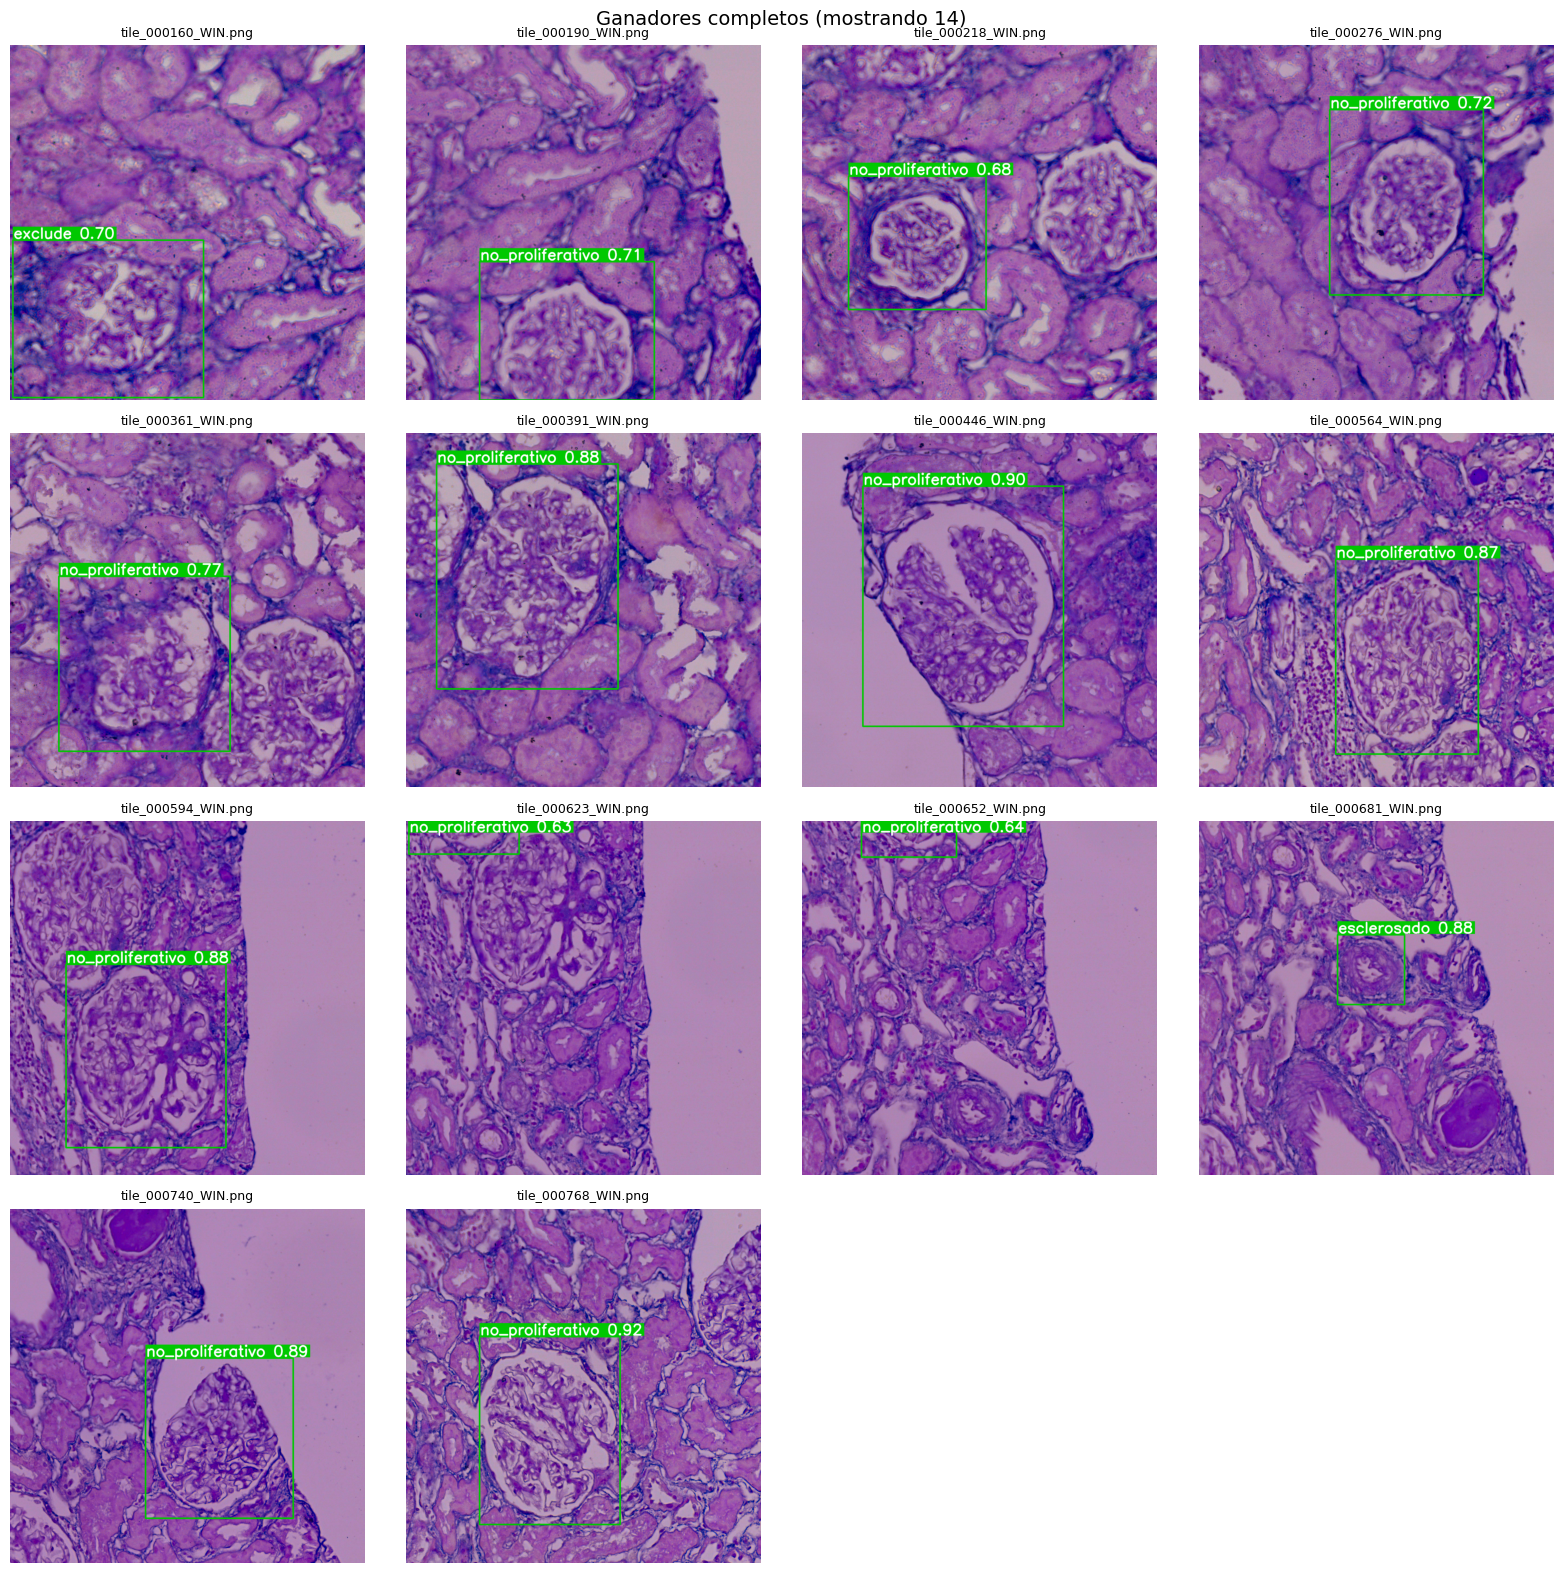

In [8]:
# === VISOR DE GANADORES GUARDADOS EN ./winners_vis ===
import os, math, glob, re
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

# ---------- CONFIG ----------
VIS_DIR       = "./winners_vis"  # carpeta que escribe el script de inferencia
SHOW_COMPLETE = True             # ver *solo* completos (_WIN.png)
SHOW_EDGE     = True             # ver ejemplos naranja (__EDGE*.png)
MAX_COMPLETE  = 50               # máximo a mostrar de completos
MAX_EDGE      = 50               # máximo a mostrar de naranjas
N_COLS        = 4                # columnas del grid
TITLE_FONTSZ  = 9                # tamaño del título debajo de cada imagen
# ----------------------------

def _natkey(s: str):
    """Clave de ordenamiento 'natural': file_2 < file_10."""
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def _show_grid(paths, title, n_cols=4, title_size=9):
    if not paths:
        print(f"(sin imágenes) {title}")
        return
    n = len(paths)
    n_rows = math.ceil(n / n_cols)
    # tamaño de figura proporcional a la rejilla
    plt.figure(figsize=(4*n_cols, 4*n_rows))
    for i, p in enumerate(paths, 1):
        img = cv2.imread(p)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(n_rows, n_cols, i)
        ax.imshow(img)
        ax.set_title(Path(p).name, fontsize=title_size)
        ax.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# --- Comprobaciones ---
if not os.path.isdir(VIS_DIR):
    raise FileNotFoundError(f"No existe la carpeta: {VIS_DIR}\n"
                            f"Corre primero el script de inferencia o ajusta VIS_DIR.")

# completos: sufijo _WIN.png (ganadores no-borde)
complete_paths = sorted(glob.glob(str(Path(VIS_DIR) / "*_WIN.png")), key=_natkey)
# naranjas: sufijo __EDGE*.png (muestras 'edge=True')
edge_paths     = sorted(glob.glob(str(Path(VIS_DIR) / "*__EDGE*.png")), key=_natkey)

print(f"Encontrados  completos (verdes): {len(complete_paths)}")
print(f"Encontrados  naranjas (edge):    {len(edge_paths)}")

# Mostrar grillas
if SHOW_COMPLETE and complete_paths:
    _show_grid(
        complete_paths[:MAX_COMPLETE],
        f"Ganadores completos (mostrando {min(len(complete_paths), MAX_COMPLETE)})",
        n_cols=N_COLS,
        title_size=TITLE_FONTSZ
    )

if SHOW_EDGE and edge_paths:
    _show_grid(
        edge_paths[:MAX_EDGE],
        f"Ejemplos naranja (mostrando {min(len(edge_paths), MAX_EDGE)})",
        n_cols=N_COLS,
        title_size=TITLE_FONTSZ
    )

if (SHOW_COMPLETE and not complete_paths) and (SHOW_EDGE and not edge_paths):
    print("No hay imágenes para mostrar en", VIS_DIR, "— corre primero el script de inferencia.")

In [9]:
# === Mostrar/guardar SOLO los 19 ganadores completos (edge=False) ===
from pathlib import Path

# Filtrar los ganadores completos
complete_winners = [w for w in winners if not w["edge"]]
print(f"Ganadores completos (no tocan borde): {len(complete_winners)}/{len(winners)}")

# Carpeta específica para estos 19
OUT_DIR_COMPLETE = "./winners_vis_complete"
draw_and_save_winners(complete_winners, OUT_DIR_COMPLETE, only_complete=True)

# (Opcional) CSV solo de completos
WINNERS_CSV_COMPLETE = "./winners_global_complete.csv"
save_winners_csv(complete_winners, WINNERS_CSV_COMPLETE)

# (Opcional) listar rápido sus tiles y clases en texto
for i, w in enumerate(complete_winners, 1):
    cname = CLASS_NAMES[w["cls"]] if 0 <= w["cls"] < len(CLASS_NAMES) else str(w["cls"])
    print(f"[{i:02d}] {Path(w['tile_path']).name}  |  {cname}  conf={w['conf']:.3f}")

Ganadores completos (no tocan borde): 14/14
✅ Tiles ganadores guardados en: ./winners_vis_complete
✅ CSV de ganadores guardado en: ./winners_global_complete.csv
[01] tile_000681.png  |  esclerosado  conf=0.876
[02] tile_000276.png  |  no_proliferativo  conf=0.719
[03] tile_000446.png  |  no_proliferativo  conf=0.896
[04] tile_000218.png  |  no_proliferativo  conf=0.684
[05] tile_000740.png  |  no_proliferativo  conf=0.893
[06] tile_000768.png  |  no_proliferativo  conf=0.918
[07] tile_000361.png  |  no_proliferativo  conf=0.773
[08] tile_000564.png  |  no_proliferativo  conf=0.870
[09] tile_000391.png  |  no_proliferativo  conf=0.883
[10] tile_000594.png  |  no_proliferativo  conf=0.880
[11] tile_000160.png  |  exclude  conf=0.698
[12] tile_000623.png  |  no_proliferativo  conf=0.629
[13] tile_000652.png  |  no_proliferativo  conf=0.635
[14] tile_000190.png  |  no_proliferativo  conf=0.705


In [10]:
# ==== CELDA INDEPENDIENTE: porcentajes por clase excluyendo 'exclude' ====
import os, csv
from collections import Counter
import pandas as pd

# Ajusta si tus nombres/clases cambian
CLASS_NAMES = ['no_proliferativo', 'proliferativo', 'esclerosado', 'exclude']
EXCLUDE_CLS = 3                       # id de la clase 'exclude'
WINNERS_CSV = "./winners_global.csv"  # salida del script anterior
OUT_CSV     = "./class_stats.csv"

def compute_stats_from_records(records, class_names=CLASS_NAMES, exclude_cls=EXCLUDE_CLS):
    cnt = Counter([int(r["cls"]) for r in records])
    total_incl = sum(cnt.values())
    excl_count = cnt.get(exclude_cls, 0)
    total_excl = total_incl - excl_count
    safe = lambda x, y: (100.0 * x / y) if y > 0 else 0.0

    rows = []
    for cid in sorted(set(cnt.keys()) | set(range(len(class_names)))):
        c = cnt.get(cid, 0)
        name = class_names[cid] if 0 <= cid < len(class_names) else str(cid)
        pct_excl = safe(c if cid != exclude_cls else 0, total_excl)
        pct_incl = safe(c, total_incl)
        rows.append({
            "class_id": cid,
            "class_name": name,
            "count": c,
            "pct_excluding_exclude": round(pct_excl, 4),
            "pct_including_total": round(pct_incl, 4)
        })

    df = pd.DataFrame(rows).sort_values("class_id")
    df.attrs["totals"] = {"total_including": total_incl, "total_excluding": total_excl}
    return df

# 1) Intentar usar 'winners' en memoria
records = None
if "winners" in globals() and isinstance(winners, list) and winners:
    # normalizamos a un dict minimal por elemento
    records = [{"cls": int(w["cls"])} for w in winners]

# 2) Si no existe 'winners', leemos el CSV
if records is None:
    if not os.path.exists(WINNERS_CSV):
        raise FileNotFoundError(f"No encuentro {WINNERS_CSV}. Corre primero el script que lo genera.")
    df_csv = pd.read_csv(WINNERS_CSV)
    records = [{"cls": int(c)} for c in df_csv["class_id"].tolist()]

# Calcular y mostrar
df_stats = compute_stats_from_records(records, CLASS_NAMES, EXCLUDE_CLS)
display(df_stats)

totals = df_stats.attrs["totals"]
print(f"\nTotal (incluyendo exclude): {totals['total_including']}")
print(f"Total (excluyendo exclude): {totals['total_excluding']}")

# Guardar CSV de métricas
df_stats.assign(
    total_including=totals["total_including"],
    total_excluding=totals["total_excluding"],
    exclude_class_id=EXCLUDE_CLS
).to_csv(OUT_CSV, index=False)
print(f"✅ CSV de estadísticas guardado en: {OUT_CSV}")


class_id        class_name  count  pct_excluding_exclude  \
0         0  no_proliferativo     12                92.3077   
1         1     proliferativo      0                 0.0000   
2         2       esclerosado      1                 7.6923   
3         3           exclude      1                 0.0000   

   pct_including_total  
0              85.7143  
1               0.0000  
2               7.1429  
3               7.1429


Total (incluyendo exclude): 14
Total (excluyendo exclude): 13
✅ CSV de estadísticas guardado en: ./class_stats.csv


In [11]:
# ===== CELDA INDEPENDIENTE: tendencia diagnóstica por porcentajes =====
import os, json, csv
from collections import Counter, OrderedDict
import pandas as pd

# ---- Configuración de clases ----
CLASS_NAMES = ['no_proliferativo', 'proliferativo', 'esclerosado', 'exclude']
EXCLUDE_CLS = 3
WINNERS_CSV = "./winners_global.csv"

# ---- Motor de reglas (ordena por prioridad) ----
# Cada regla es (condición, etiqueta, nota)
# La condición recibe un dict con: pct, count, total_excl, total_incl, lead, top, runner_up
# pct es {class_id: porcentaje_excluyendo_exclude}
RULES = [
    # 0) salvaguardas
    (lambda s: s["total_excl"] < 10, 
     "muestra insuficiente", 
     "Menos de 10 glomérulos válidos (excluyendo 'exclude')."),

    # 1) dominancias claras por umbral absoluto (cámbialos a tu criterio)
    (lambda s: s["pct"].get(2, 0) >= 50.0, "tendencia esclerosado",
     "≥50% de glomérulos esclerosados (excluyendo 'exclude')."),
    (lambda s: s["pct"].get(1, 0) >= 50.0, "tendencia proliferativo",
     "≥50% de glomérulos proliferativos (excluyendo 'exclude')."),
    (lambda s: s["pct"].get(0, 0) >= 50.0, "tendencia no_proliferativo",
     "≥50% de glomérulos no proliferativos (excluyendo 'exclude')."),

    # 2) dominancia por liderazgo (top >= 40% y ventaja ≥ 15 pp)
    (lambda s: s["pct"].get(s["top"], 0) >= 40.0 and s["lead"] >= 15.0,
     "tendencia " + "{top_name}",
     "Clase dominante ≥40% y ventaja ≥15 puntos porcentuales."),

    # 3) mezcla: dos primeras ≥30% cada una (posible mixto)
    (lambda s: s["pct"].get(s["top"], 0) >= 30.0 and s["pct"].get(s["runner_up"], 0) >= 30.0,
     "mixto/indeterminado",
     "Dos clases con ≥30% cada una sin dominancia clara."),

    # 4) por defecto
    (lambda s: True, "indeterminado", "Sin criterio de dominancia alcanzado."),
]

def _load_records():
    # 1) usar winners en memoria si existe
    if "winners" in globals() and isinstance(winners, list) and winners:
        return [int(w["cls"]) for w in winners]
    # 2) si no, leer CSV
    if not os.path.exists(WINNERS_CSV):
        raise FileNotFoundError(f"No encuentro {WINNERS_CSV} ni la variable 'winners'.")
    df = pd.read_csv(WINNERS_CSV)
    return [int(x) for x in df["class_id"].tolist()]

def _compute_stats(class_ids, exclude_cls=EXCLUDE_CLS, class_names=CLASS_NAMES):
    cnt = Counter(class_ids)
    total_incl = sum(cnt.values())
    excl_count  = cnt.get(exclude_cls, 0)
    total_excl  = total_incl - excl_count
    def safe(x, y): return (100.0 * x / y) if y > 0 else 0.0

    # porcentajes EXCLUYENDO exclude
    pct_excl = {}
    for cid in range(len(class_names)):
        c = cnt.get(cid, 0)
        pct_excl[cid] = safe(c if cid != exclude_cls else 0, total_excl)

    # ranking por porcentaje (excl.)
    ranked = sorted([cid for cid in pct_excl if cid != exclude_cls],
                    key=lambda c: (pct_excl[c], cnt.get(c,0)), reverse=True)
    top = ranked[0] if ranked else None
    runner = ranked[1] if len(ranked) > 1 else None
    lead = (pct_excl.get(top, 0) - pct_excl.get(runner, 0)) if top is not None and runner is not None else 0.0

    table = []
    for cid in range(len(class_names)):
        table.append({
            "class_id": cid,
            "class_name": class_names[cid] if 0 <= cid < len(class_names) else str(cid),
            "count": cnt.get(cid, 0),
            "pct_excl": round(pct_excl.get(cid, 0), 2),
            "pct_incl": round((100.0 * cnt.get(cid,0) / total_incl) if total_incl>0 else 0.0, 2),
        })

    stats = {
        "counts": dict(cnt),
        "pct": pct_excl,
        "total_incl": total_incl,
        "total_excl": total_excl,
        "exclude_count": excl_count,
        "top": top, "runner_up": runner, "lead": round(lead, 2),
        "table": table
    }
    return stats

def _apply_rules(stats):
    # construimos el estado para reglas
    state = {
        "pct": stats["pct"],
        "count": stats["counts"],
        "total_excl": stats["total_excl"],
        "total_incl": stats["total_incl"],
        "lead": stats["lead"],
        "top": stats["top"],
        "runner_up": stats["runner_up"],
    }
    top_name = CLASS_NAMES[state["top"]] if state["top"] is not None and 0 <= state["top"] < len(CLASS_NAMES) else "desconocido"

    for cond, label, note in RULES:
        ok = cond(state)
        if ok:
            # soporta {top_name} en etiqueta o nota
            lbl = label.replace("{top_name}", top_name)
            msg = note.replace("{top_name}", top_name)
            return lbl, msg
    return "indeterminado", "Sin regla aplicable (fallback)."

def diagnose_tendency():
    class_ids = _load_records()
    stats = _compute_stats(class_ids)
    label, rationale = _apply_rules(stats)

    # armar salida resumida
    summary = OrderedDict()
    summary["diagnosis_tendency"] = label
    summary["rationale"] = rationale
    summary["totals"] = {
        "including_exclude": stats["total_incl"],
        "excluding_exclude": stats["total_excl"],
        "exclude_count": stats["exclude_count"]
    }
    summary["leader"] = {
        "class_id": stats["top"],
        "class_name": CLASS_NAMES[stats["top"]] if stats["top"] is not None else None,
        "lead_over_runner_up_pp": stats["lead"]
    }
    # tabla bonita
    df = pd.DataFrame(stats["table"]).sort_values("class_id")
    print("=== Porcentajes por clase (excluyendo 'exclude' del denominador) ===")
    display(df)
    print(f"\nTendencia: {label}  |  Motivo: {rationale}")
    print(f"Total incl.: {stats['total_incl']}  |  Total excl.: {stats['total_excl']}  |  Lead: {stats['lead']} pp")

    # guardar archivos
    with open("diagnostic_summary.json", "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)
    df.assign(total_including=stats["total_incl"],
              total_excluding=stats["total_excl"]).to_csv("diagnostic_summary.csv", index=False)
    print("✅ Guardado diagnostic_summary.json y diagnostic_summary.csv")
    return summary

# Ejecutar
summary = diagnose_tendency()
summary


=== Porcentajes por clase (excluyendo 'exclude' del denominador) ===


class_id        class_name  count  pct_excl  pct_incl
0         0  no_proliferativo     12     92.31     85.71
1         1     proliferativo      0      0.00      0.00
2         2       esclerosado      1      7.69      7.14
3         3           exclude      1      0.00      7.14


Tendencia: tendencia no_proliferativo  |  Motivo: ≥50% de glomérulos no proliferativos (excluyendo 'exclude').
Total incl.: 14  |  Total excl.: 13  |  Lead: 84.62 pp
✅ Guardado diagnostic_summary.json y diagnostic_summary.csv


OrderedDict([('diagnosis_tendency', 'tendencia no_proliferativo'),
             ('rationale',
              "≥50% de glomérulos no proliferativos (excluyendo 'exclude')."),
             ('totals',
              {'including_exclude': 14,
               'excluding_exclude': 13,
               'exclude_count': 1}),
             ('leader',
              {'class_id': 0,
               'class_name': 'no_proliferativo',
               'lead_over_runner_up_pp': 84.62})])

In [12]:
# ==== CELDA: tendencia diagnóstica ISN/RPS por porcentajes ====
import os, json
import pandas as pd
from collections import Counter, OrderedDict

# Config de clases según tu modelo
CLASS_NAMES = ['no_proliferativo', 'proliferativo', 'esclerosado', 'exclude']
IDX_NOPRO, IDX_PROLIF, IDX_ESCL, IDX_EXCL = 0, 1, 2, 3
WINNERS_CSV = "./winners_global.csv"

# Umbrales operacionales (ajustables)
THR_VI_ESCL = 90.0      # ≥90% esclerosado -> clase VI
THR_IV_PROL = 50.0      # ≥50% proliferativo -> clase IV
MIN_III_PROL = 10.0     # ≥10% y <50% proliferativo -> clase III

def _load_class_ids():
    # 1) winners en memoria
    if "winners" in globals() and isinstance(winners, list) and winners:
        return [int(w["cls"]) for w in winners]
    # 2) CSV
    if not os.path.exists(WINNERS_CSV):
        raise FileNotFoundError(f"No encuentro {WINNERS_CSV} ni 'winners' en memoria.")
    df = pd.read_csv(WINNERS_CSV)
    return [int(x) for x in df["class_id"].tolist()]

def _percentages_excluding(class_ids, exclude_idx=IDX_EXCL):
    cnt = Counter(class_ids)
    total_incl = sum(cnt.values())
    excl_count  = cnt.get(exclude_idx, 0)
    total_excl  = total_incl - excl_count
    def pct(x): 
        return (100.0 * x / total_excl) if total_excl > 0 else 0.0
    p_no   = pct(cnt.get(IDX_NOPRO, 0))
    p_pro  = pct(cnt.get(IDX_PROLIF, 0))
    p_escl = pct(cnt.get(IDX_ESCL, 0))
    table = pd.DataFrame({
        "class_id":[IDX_NOPRO, IDX_PROLIF, IDX_ESCL, IDX_EXCL],
        "class_name":[CLASS_NAMES[i] for i in range(len(CLASS_NAMES))],
        "count":[cnt.get(i,0) for i in range(len(CLASS_NAMES))],
        "pct_excl":[round(p_no,2), round(p_pro,2), round(p_escl,2), 0.0],
        "pct_incl":[round(100.0*cnt.get(i,0)/total_incl,2) if total_incl>0 else 0.0 for i in range(len(CLASS_NAMES))]
    }).sort_values("class_id")
    meta = {"total_including": total_incl, "total_excluding": total_excl, "exclude_count": excl_count}
    return {"p_no":p_no, "p_pro":p_pro, "p_escl":p_escl, "cnt":cnt, "table":table, "meta":meta}

def diagnose_tendency_isnrps():
    ids = _load_class_ids()
    stats = _percentages_excluding(ids)
    p_no, p_pro, p_escl = stats["p_no"], stats["p_pro"], stats["p_escl"]
    meta = stats["meta"]

    # Reglas
    if p_escl >= THR_VI_ESCL:
        label = "tendencia VI (esclerosis avanzada)"
        rationale = f"Esclerosado {p_escl:.1f}% (≥{THR_VI_ESCL}%)."
    elif p_pro >= THR_IV_PROL:
        label = "tendencia IV (difusa proliferativa)"
        rationale = f"Proliferativo {p_pro:.1f}% (≥{THR_IV_PROL}%)."
    elif p_pro >= MIN_III_PROL:
        label = "tendencia III (focal proliferativa)"
        rationale = f"Proliferativo {p_pro:.1f}% (entre {MIN_III_PROL}–{THR_IV_PROL-0.01}%)."
    else:
        label = "tendencia no proliferativa (I/II/V)"
        rationale = f"Proliferativo {p_pro:.1f}% (<{MIN_III_PROL}%) y esclerosis {p_escl:.1f}% (<{THR_VI_ESCL}%)."

    # Mostrar y guardar
    print("=== Porcentajes excluyendo 'exclude' ===")
    display(stats["table"])
    print(f"\nTendencia: {label}")
    print(f"Motivo: {rationale}")
    print(f"Totales -> incl: {meta['total_including']} | excl: {meta['total_excluding']} | exclude: {meta['exclude_count']}")

    summary = OrderedDict(
        diagnosis_tendency=label,
        rationale=rationale,
        totals=meta,
        thresholds=dict(
            VI_esclerosis_ge=THR_VI_ESCL,
            IV_proliferativo_ge=THR_IV_PROL,
            III_proliferativo_range=f"{MIN_III_PROL}-{THR_IV_PROL-0.01}"
        )
    )
    with open("diagnostic_summary.json","w",encoding="utf-8") as f:
        json.dump(summary,f,ensure_ascii=False,indent=2)
    stats["table"].assign(**meta).to_csv("diagnostic_summary.csv", index=False)
    print("✅ Guardado diagnostic_summary.json y diagnostic_summary.csv")
    return summary

summary = diagnose_tendency_isnrps()
summary


=== Porcentajes excluyendo 'exclude' ===


class_id        class_name  count  pct_excl  pct_incl
0         0  no_proliferativo     12     92.31     85.71
1         1     proliferativo      0      0.00      0.00
2         2       esclerosado      1      7.69      7.14
3         3           exclude      1      0.00      7.14


Tendencia: tendencia no proliferativa (I/II/V)
Motivo: Proliferativo 0.0% (<10.0%) y esclerosis 7.7% (<90.0%).
Totales -> incl: 14 | excl: 13 | exclude: 1
✅ Guardado diagnostic_summary.json y diagnostic_summary.csv


OrderedDict([('diagnosis_tendency', 'tendencia no proliferativa (I/II/V)'),
             ('rationale',
              'Proliferativo 0.0% (<10.0%) y esclerosis 7.7% (<90.0%).'),
             ('totals',
              {'total_including': 14,
               'total_excluding': 13,
               'exclude_count': 1}),
             ('thresholds',
              {'VI_esclerosis_ge': 90.0,
               'IV_proliferativo_ge': 50.0,
               'III_proliferativo_range': '10.0-49.99'})])